In [29]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import unicodedata
import contractions
import inflect
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer as k_tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from tqdm import tqdm
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, LSTM, Dropout, GRU, Input, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import concatenate

[nltk_data] Downloading package stopwords to /Users/arwan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_df = pd.DataFrame()
train_df = pd.read_csv('trainingandtestdata/training.1600000.processed.noemoticon.csv',
                       encoding='latin-1',
                       names=["Label", "Index", "Date", "Tag", "User", "Text"])

train_df["Label"] = train_df["Label"].apply(lambda x: int(x / 4))
# Shuffle dataset
train_df = train_df.sample(frac=1).reset_index(drop=True)

x_train = train_df.loc[10000:499999, 'Text'].values
y_train = train_df.loc[10000:499999, 'Label'].values
# y_train = to_categorical(y_train, num_classes=3)
x_test = train_df.loc[:9999, 'Text'].values
y_test = train_df.loc[:9999, 'Label'].values
# y_test = to_categorical(y_test, num_classes=3)

print(len(x_train), len(y_train), len(x_test), len(y_test))
train_df.head()


490000 490000 10000 10000


,Label,Index,Date,Tag,User,Text
0,0,2056819748,Sat Jun 06 11:51:17 PDT 2009,NO_QUERY,tinzlin,"@Jen8or9 no, i missed an important step on you..."
1,1,2049185845,Fri Jun 05 16:26:41 PDT 2009,NO_QUERY,mi5tery,"Finally! 3 hours later, hotel room booked! Awe..."
2,1,1834931604,Mon May 18 04:39:10 PDT 2009,NO_QUERY,wfaler,@RonJeffries http://is.gd/7hsH It's probably t...
3,0,2302610883,Tue Jun 23 17:03:02 PDT 2009,NO_QUERY,AnimatedCStina,Usually I'm the one pissed and tired after a b...
4,0,1988708562,Sun May 31 23:08:45 PDT 2009,NO_QUERY,kaylamayla,I need to sleep. But I can't


In [6]:
# Data normalization

def clean_tweet(sentence):
    # Remove or convert non-ASCII characters
    new_words = []
    for word in sentence.split():
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    str1 = " "
    sentence = (str1.join(new_words))
    
    # Removing URLs
    sentence = re.sub(r"http\S+", "", sentence)
    
    # Replace contractions
    sentence = contractions.fix(sentence)
    
    # Remove punctuations (emojis, '@', '#', etc...)
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    # Replace numbers by their string using inflect
    p = inflect.engine()
    new_words = []
    for word in sentence.split():
        if word.isdigit():
            try:
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            except:
                pass
        else:
            new_words.append(word)
    str1 = " "
    sentence = (str1.join(new_words))
    
    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Remove stop-words (usualy common words under 3 letters that don't add any info)
#     new_words = []
#     for word in sentence.split():
#         if word not in stopwords.words('english'):
#             new_words.append(word)
#     str1 = " "
#     sentence = (str1.join(new_words))
    
    # Stem the tokens
#     stemmer = LancasterStemmer()
#     stems = []
#     for word in sentence.split():
#         stem = stemmer.stem(word)
#         stems.append(stem)
#     str1 = " "
#     sentence = (str1.join(stems))
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lowercasing
    sentence = sentence.lower()
    
    return sentence

# Example
print(clean_tweet("http://bbc.in/1BO3eWQ Check it quickly héhé ! 网络 This isn't a test. I got 10 good answers! :) #LOL @brian"))

check it quickly hehe this is not test got ten good answers lol brian


In [7]:
x_train = [clean_tweet(tweet) for tweet in tqdm(x_train)]
x_test = [clean_tweet(tweet) for tweet in tqdm(x_test)]


 31%|███▏      | 153864/490000 [00:14<00:45, 7320.18it/s]


 63%|██████▎   | 309711/490000 [00:28<00:17, 10171.29it/s]


 95%|█████████▌| 466543/490000 [00:42<00:02, 11305.00it/s]


100%|██████████| 490000/490000 [00:44<00:00, 10998.98it/s]

100%|██████████| 10000/10000 [00:00<00:00, 11529.15it/s][A


In [8]:
tokenizer = k_tokenizer()
total_texts = [*x_train, *x_test] 
tokenizer.fit_on_texts(total_texts)

max_sequence = max([len(s.split()) for s in total_texts])
# max_sequence = 400
vocab_size = len(tokenizer.word_index) + 1
print('vocab size =', vocab_size)
print('max sequence size =', max_sequence)

x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

x_train_padded = pad_sequences(x_train_tokens, maxlen=max_sequence, padding='post')
x_test_padded = pad_sequences(x_test_tokens, maxlen=max_sequence, padding='post')

vocab size = 334711
max sequence size = 56


In [9]:
embeddings_dict = dict()
glove_word_vectors = open('glove.twitter.27B/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in glove_word_vectors:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dict [word] = vector_dimensions
glove_word_vectors.close()

In [10]:
emb_dim = 100
embedding_matrix = np.zeros((vocab_size, emb_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [30]:
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

model = Sequential()
model.add(Embedding(vocab_size,
                    emb_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence,
                    trainable=False))
# model.add(LSTM(8))
# model.add(LSTM(8))
# model.add(Flatten())
# model.add(Dropout(0.1))
# model.add(Dense(250, activation='relu'))
# model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='sigmoid'))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta',  metrics=['acc'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 56, 100)           33471100  
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 56, 32)            3232      
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 32)            128       
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 55, 32)            2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 55, 32)            128       
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 53, 32)            3104      
_________________________________________________________________
batch_normalization_3 (Batch (None, 53, 32)          

In [31]:
checkpoint = ModelCheckpoint("models/latest_1_model.hdf5", 
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             period=1)

early_stop = EarlyStopping(monitor='val_acc',
                           patience=5,
                           verbose=1,
                           mode='auto')

history = model.fit(x_train_padded,
                    y_train,
                    validation_data=(x_test_padded, y_test), 
                    epochs=100,  
                    verbose=1,
                    callbacks=[checkpoint, early_stop],
                    batch_size=128
                   )

# model.save('models/conv_dense_end_model.h5')

Train on 490000 samples, validate on 10000 samples
Epoch 1/100
490000/490000 [==============================] - 224s 457us/step - loss: 0.4690 - acc: 0.7732 - val_loss: 0.4368 - val_acc: 0.7981

Epoch 00001: val_acc improved from -inf to 0.79810, saving model to models/latest_1_model.hdf5
Epoch 2/100
490000/490000 [==============================] - 214s 438us/step - loss: 0.4264 - acc: 0.8022 - val_loss: 0.4242 - val_acc: 0.8058

Epoch 00002: val_acc improved from 0.79810 to 0.80580, saving model to models/latest_1_model.hdf5
Epoch 3/100
490000/490000 [==============================] - 212s 432us/step - loss: 0.4157 - acc: 0.8085 - val_loss: 0.4277 - val_acc: 0.8077

Epoch 00003: val_acc improved from 0.80580 to 0.80770, saving model to models/latest_1_model.hdf5
Epoch 4/100
490000/490000 [==============================] - 221s 451us/step - loss: 0.4095 - acc: 0.8122 - val_loss: 0.4123 - val_acc: 0.8121

Epoch 00004: val_acc improved from 0.80770 to 0.81210, saving model to models/late

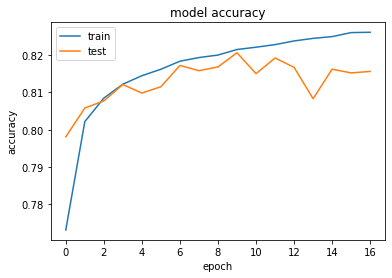

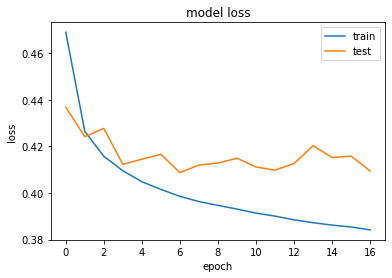

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
# plt.savefig('k=1,2,3_acc_2.png', dpi=200)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
# plt.savefig('k=1,2,3_loss_2.png', dpi=200)
plt.show()

In [ ]:
# Predict
loaded_model = load_model('models/full_model.hdf5')
# sentence = ["I hate my friends, but i love this teacher."]
# sentence = ["I love my friends, but i hate this teacher."]
# sentence = ["Hate this teacher. I am not happy..."]
# sentence = ["Love this teacher. I am really happy at school."]
sentence = ["This statement is a statement. Is it normal that the middle value isn't changing ?"]
sequence = k_tokenizer.texts_to_sequences(sentence)
sequence_padded = pad_sequences(sequence, padding='post', maxlen=max_sequence)

res = model.predict(sequence_padded)
print(res)

res = model.predict(x_test_padded)
# print("{0:20}{1:20}".format("Negative","Positive"))
# print("{0:20}{1:20}".format("%.3f" % result[0, 0], "%.3f" % result[0, 1]))
# print(np.argmax(result))
y_val = np.zeros(len(x_test_padded))
# y_val = range(len(x_test_padded))
plt.scatter(y_val, res)

In [ ]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig, axs = plt.subplots(2, 2, figsize=(20,15))
# sigmas = [0, 16, 32, 64]
# sigmas = [0, 1, 3, 5]
sigmas = [0, 35, 40, 45]

for ax, s in zip(axs.flatten(), sigmas):
    ax.set_ylim([0, 1])
    if s == 0:
        ax.plot(y_flat, rez_flat, 'k.', markersize=2)
        ax.set_title("Scatter plot")
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        img, extent = myplot(y_flat, rez_flat, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)
        ax.xaxis.set_major_formatter(plt.NullFormatter())

# plt.savefig('sentiment_heatmap.png', dpi=400)
plt.show()